In [29]:
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from itertools import combinations
from src.utils.helpers import convert_csv, assign_side
from src.constants import *

In [30]:
movies = pd.read_csv(DATA_FOLDER_PREPROCESSED + "preprocessed_movies.csv")
convert_csv(movies).head()

,wikipedia_id,freebase_id,title,languages,countries,genres,keywords,release_date,runtime,plot_summary,cold_war_side,character_western_bloc_representation,character_eastern_bloc_representation,western_bloc_values,eastern_bloc_values,theme
0,4213160.0,/m/0bq8q8,$,NaN,[Russia],"[Comedy, Crime, Drama]",NaN,1971,119.0,"Set in Hamburg, West Germany, several criminal...",Western,"[Joe Collins, American bank security consultan...","[Dawn Divine, hooker with a heart of gold, cun...",[None],"[Resourcefulness, cleverness, individualism, h...",[None]
1,NaN,NaN,"$1,000 on the Black","[German, Italian]","[Germany, Italy]",[Western],NaN,1966,104.0,Johnny Liston has just been released from pris...,Eastern,[None],"[Sartana, villainous, oppressive, cruel, arche...","[Johnny Liston, justice, determination, resili...","[Justice, revenge, oppressed vs. oppressor, re...","[Terror, betrayal, familial conflict, crime, r..."
2,NaN,NaN,"$10,000 Blood Money",NaN,[Russia],"[Western, Drama]",NaN,1967,NaN,Hired by a Mexican landowner to rescue his dau...,None,[None],[None],[None],[None],"[crime, betrayal, revenge, bounty hunter, heis..."
3,NaN,NaN,"$100,000 for Ringo",[Italian],[Italy],"[Western, Drama]","[spaghetti western, whipping]",1965,98.0,A stranger rides into Rainbow Valley where he'...,None,[None],[None],[None],[None],"[Western, Civil War, mistaken identity, treasu..."
4,NaN,NaN,'Anna' i wampir,NaN,[Russia],[Crime],NaN,1982,NaN,"Silesia in Poland, late 60s. Bodies of vicious...",None,[None],[None],[None],[None],"[murder mystery, horror, fog, Poland, 1960s]"


In [31]:
country_film_count = Counter()
collaboration_count = Counter()

for countries in movies['countries']:
    country_film_count.update(countries)
    # Generate all unique combinations of two countries and count the collaborations
    for pair in combinations(countries, 2):
        collaboration_count[tuple(sorted(pair))] += 1  # Sort the pair to avoid duplicate keys (e.g., (A, B) and (B, A))

# Keep only countries that have produced more than 40 films
country_film_count = {k: v for k, v in country_film_count.items() if v > 40}

# Compute the square root of the number of films for each country, and store in a new dictionary
root_film_count = {country: np.sqrt(count) for country, count in country_film_count.items()}

# Get a list of all the countries
countries = list(root_film_count.keys())

# Keep only collaborations that happened more than 10 times
collaboration_count = {k: v for k, v in collaboration_count.items() if v > 10}

# Make sure we have the same coutries than in our list of countries
collaboration_count = {k: v for k, v in collaboration_count.items() if k[0] in countries and k[1] in countries}


In [32]:
country_cold_war_side = assign_side(movies, countries, threshold=19)


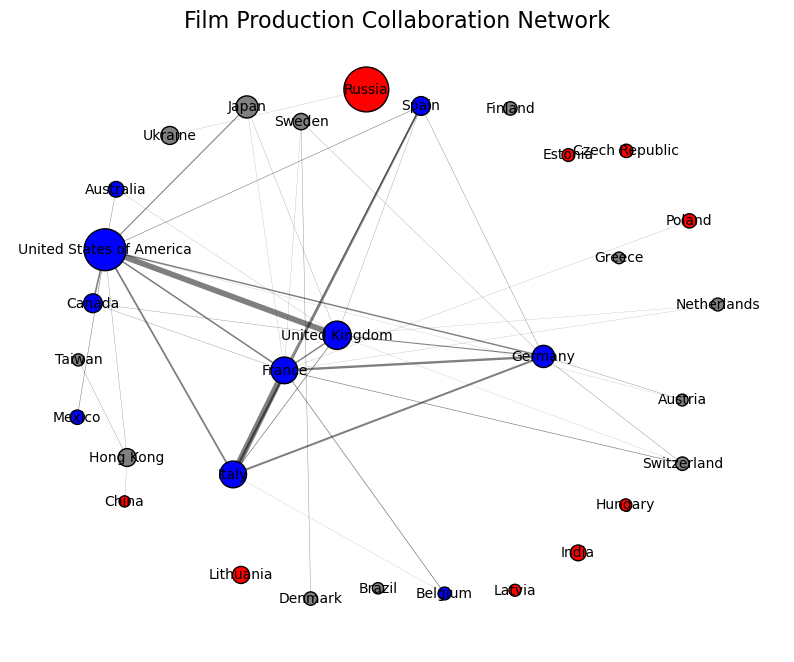

In [33]:
# With matplotlib
G = nx.Graph()
for country in countries:
    G.add_node(country, side=country_cold_war_side[country], size=root_film_count[country])

for (c1, c2), count in collaboration_count.items():
    G.add_edge(c1, c2, weight=count)

node_colors = [
    'blue' if G.nodes[n]['side'] == 'Western' else
    'red' if G.nodes[n]['side'] == 'Eastern' else 'grey'
    for n in G.nodes
]

node_sizes = [G.nodes[n]['size'] * 10 for n in G.nodes] 

edge_weights = [G[u][v]['weight'] for u, v in G.edges]
edge_widths = [weight * 0.01 for weight in edge_weights]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=10)
nx.draw_networkx_edges(G, pos, alpha=0.5, width=edge_widths)
nx.draw_networkx_nodes(
    G, pos, node_color=node_colors, edgecolors='black', node_size=node_sizes
)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

plt.title("Film Production Collaboration Network", fontsize=16)
plt.axis('off')
plt.show()

In [34]:
# With plotly
G = nx.Graph()
for country in countries:
    G.add_node(country, side=country_cold_war_side[country], size=root_film_count[country])

for (c1, c2), count in collaboration_count.items():
    G.add_edge(c1, c2, weight=count)

pos = nx.spring_layout(G, seed=42, k=10, iterations=100)
edge_x = []
edge_y = []
edge_weights = []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_weights.append(G[edge[0]][edge[1]]['weight'])

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='black'),
    hoverinfo='none',
    mode='lines'
)

node_x = []
node_y = []
node_colors = []
node_sizes = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    if G.nodes[node]['side'] == 'Western':
        node_colors.append('blue')
    elif G.nodes[node]['side'] == 'Eastern':
        node_colors.append('red')
    else:
        node_colors.append('grey')
    node_sizes.append(G.nodes[node]['size'] * 0.5)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    hoverinfo='text',
    hovertext=[node for node in G.nodes()],
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=node_sizes,
        color=node_colors,
        colorbar=dict(
            thickness=15,
            title='Cold War Side',
            xanchor='left',
            titleside='right'
        )
    )
)

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Film Production Collaboration Network',
                    showlegend=False,
                    hovermode='closest',
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False),
                    plot_bgcolor='white'
                ))

fig.show()

In [35]:
# Have been generated with GPT
country_coords = {
    'United States of America': (37.0902, -95.7129),
    'Italy': (41.8719, 12.5674),
    'Germany': (51.1657, 10.4515),
    'Russia': (61.5240, 105.3188),
    'Hungary': (47.1625, 19.5033),
    'Estonia': (58.5953, 25.0136),
    'Ukraine': (48.3794, 31.1656),
    'Switzerland': (46.8182, 8.2275),
    'Puerto Rico': (18.2208, -66.5901),
    'France': (46.6034, 1.8883),
    'Egypt': (26.8206, 30.8025),
    'Netherlands': (52.1326, 5.2913),
    'Japan': (36.2048, 138.2529),
    'United Kingdom': (55.3781, -3.4360),
    'Hong Kong': (22.3193, 114.1694),
    'India': (20.5937, 78.9629),
    'Spain': (40.4637, -3.7492),
    'Costa Rica': (9.7489, -83.7534),
    'Vietnam': (14.0583, 108.2772),
    'Taiwan': (23.6978, 120.9605),
    'Australia': (-25.2744, 133.7751),
    'Canada': (56.1304, -106.3468),
    'Latvia': (56.8796, 24.6032),
    'Brazil': (-14.2350, -51.9253),
    'Turkey': (38.9637, 35.2433),
    'Denmark': (56.2639, 9.5018),
    'Poland': (51.9194, 19.1451),
    'Korea': (35.9078, 127.7669),
    'Norway': (60.4720, 8.4689),
    'Croatia': (45.1, 15.2),
    'Bulgaria': (42.7339, 25.4858),
    'Austria': (47.5162, 14.5501),
    'Philippines': (12.8797, 121.7740),
    'Lithuania': (55.1694, 23.8813),
    'Portugal': (39.3999, -8.2245),
    'China': (35.8617, 104.1954),
    'Romania': (45.9432, 24.9668),
    'Georgia': (42.3154, 43.3569),
    'Yugoslavia': (44.0165, 21.0059),
    'New Zealand': (-40.9006, 174.8860),
    'Czechoslovakia': (49.8175, 15.4729),
    'Argentina': (-38.4161, -63.6167),
    'Greece': (39.0742, 21.8243),
    'South Africa': (-30.5595, 22.9375),
    'Luxembourg': (49.8153, 6.1296),
    'Sweden': (60.1282, 18.6435),
    'Ireland': (53.1424, -7.6921),
    'Colombia': (4.5709, -74.2973),
    'Uruguay': (-32.5228, -55.7658),
    'Belgium': (50.5039, 4.4699),
    'Czech Republic': (49.8175, 15.4729),
    'Bangladesh': (23.6850, 90.3563),
    'Tunisia': (33.8869, 9.5375),
    'Albania': (41.1533, 20.1683),
    'Finland': (61.9241, 25.7482),
    'Iceland': (64.9631, -19.0208),
    'Liechtenstein': (47.1660, 9.5554),
    'Mexico': (23.6345, -102.5528),
    'Iran': (32.4279, 53.6880),
    'Zimbabwe': (-19.0154, 29.1549),
    'Nepal': (28.3949, 84.1240),
    'Uzbekistan': (41.3775, 64.5853),
    'Venezuela': (6.4238, -66.5897),
    'Bosnia and Herzegovina': (43.9159, 17.6791),
    'Cuba': (21.5218, -77.7812),
    'Peru': (-9.1899, -75.0152),
    'Malaysia': (4.2105, 101.9758),
    'Pakistan': (30.3753, 69.3451),
    'Sri Lanka': (7.8731, 80.7718),
    'Algeria': (28.0339, 1.6596),
    'Israel': (31.0461, 34.8516),
    'Singapore': (1.3521, 103.8198),
    'Morocco': (31.7917, -7.0926),
    'Azerbaijan': (40.1431, 47.5769),
    'Bolivia': (-16.2902, -63.5887),
    'Cameroon': (7.3697, 12.3547),
    'Serbia': (44.0165, 21.0059),
    'Mali': (17.5707, -3.9962),
    'Macedonia': (41.6086, 21.7453),
    'Monaco': (43.7384, 7.4246),
    'Slovakia': (48.6690, 19.6990),
    'Senegal': (14.4974, -14.4524),
    'Qatar': (25.2760, 51.2148),
    'Thailand': (15.8700, 100.9925),
    "Côte d'Ivoire": (7.5399, -5.5471),
    'Belarus': (53.7098, 27.9534),
    'Armenia': (40.0691, 45.0382),
    'Chile': (-35.6751, -71.5430),
    'Cambodia': (12.5657, 104.9910),
    'Ghana': (7.9465, -1.0232),
    'Jamaica': (18.1096, -77.2975),
    'Slovenia': (46.1512, 14.9955),
    'Guinea': (9.9456, -9.6966),
    'Afghanistan': (33.9391, 67.7100),
    'Democratic Republic of the Congo': (-4.0383, 21.7587),
    'Indonesia': (-0.7893, 113.9213),
    'Montenegro': (42.7087, 19.3744),
    'Namibia': (-22.9576, 18.4904),
    'Moldova': (47.4116, 28.3699),
    'Panama': (8.5379, -80.7821),
    'Burkina Faso': (12.2383, -1.5616),
    'Aruba': (12.5211, -69.9683),
    'Ethiopia': (9.145, 40.4897),
    'Jordan': (30.5852, 36.2384),
    'Kazakhstan': (48.0196, 66.9237),
    'Nigeria': (9.0820, 8.6753),
    'Libya': (26.3351, 17.2283),
    'Congo': (-0.2280, 15.8277),
    'Turkmenistan': (38.9697, 59.5563),
    'Bhutan': (27.5142, 90.4336),
    'Kuwait': (29.3117, 47.4818),
    'Lebanon': (33.8547, 35.8623),
    'Guinea-Bissau': (11.8037, -15.1804),
    'Mauritania': (21.0079, -10.9408),
    'Angola': (-11.2027, 17.8739),
    'Burma': (21.9162, 95.9560),
    'Martinique': (14.6415, -61.0242),
    'Trinidad and Tobago': (10.6918, -61.2225),
    'Bahrain': (26.0667, 50.5577),
    'Syria': (34.8021, 38.9968),
    'Kyrgyzstan': (41.2044, 74.7661),
    'Botswana': (-22.3285, 24.6849),
    'Zambia': (-13.1339, 27.8493),
    'Bahamas': (25.0343, -77.3963),
    'Papua New Guinea': (-6.3149, 143.9555),
    'Ecuador': (-1.8312, -78.1834),
    'Palestinian Territory': (31.9522, 35.2332)
}

In [36]:
# Map country coordinates
node_lat = []
node_lon = []
node_sizes = []
node_colors = []
for country in countries:
    if country in country_coords:
        node_lat.append(country_coords[country][0])
        node_lon.append(country_coords[country][1])
        node_sizes.append(root_film_count[country] * 0.5)  
        # Assign color based on Cold War side
        node_colors.append(
            'blue' if country_cold_war_side.get(country) == 'Western' else
            'red' if country_cold_war_side.get(country) == 'Eastern' else
            'grey'
        )

# Prepare edges
edge_lat = []
edge_lon = []
for (c1, c2), weight in collaboration_count.items():
    if c1 in country_coords and c2 in country_coords:
        edge_lat.extend([country_coords[c1][0], country_coords[c2][0], None])
        edge_lon.extend([country_coords[c1][1], country_coords[c2][1], None])

# Create the map
fig = go.Figure()

# Add edges
fig.add_trace(go.Scattergeo(
    locationmode='ISO-3',
    lat=edge_lat,
    lon=edge_lon,
    mode='lines',
    line=dict(width=1, color='black'),
    hoverinfo='none'
))

# Add nodes
fig.add_trace(go.Scattergeo(
    locationmode='ISO-3',
    lat=node_lat,
    lon=node_lon,
    mode='markers',
    marker=dict(
        size=node_sizes,
        color=node_colors,
        line=dict(width=0.5, color='black')
    ),
    text=countries,
    hoverinfo='text'
))

# Mapbox configuration
fig.update_layout(
    title='Film Production Collaboration Network on a Map',
    showlegend=False,
    geo=dict(
        projection_type='natural earth',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        showcountries=True,
    )
)

# Show the map
fig.show()

In [38]:
sides = movies.loc[movies['countries'].apply(lambda x: 'Germany' in x), 'cold_war_side'].values
west_count = (sides == 'Western').sum()
east_count = (sides == 'Eastern').sum()
none_count = (sides == 'None').sum()
print(west_count)
print(east_count)
print(none_count)
percentage_difference = (abs(west_count - east_count) / (west_count + east_count)) * 100
print(percentage_difference)

68
42
535
23.636363636363637
